# Creating random training data polygons

Using Collect Earth Online (CEO), these randomly scattered polygons will be classified as crop, non-crop, or mixed and form the knowledge base for the machine learning classifier.

Stratifying points using the GFSAD cropland extent map (30m resolution).
    
    import os
    os.chdir('data/GFSAD/')
    gdalwarp -tr 0.0005389891704717132 0.0005389891704717132  -r mode GFSAD_mosaic.tif GFSAD_mosaic_60m.tif

> TODO: Add an extra column identifying the GFSAD class (not just whether it came from the dataset). Use the label `GFSAD_CLASS`

### Load modules

In [1]:
import geopandas as gpd
from datacube.utils.cog import write_cog
import xarray as xr
import numpy as np
import pandas as pd
import datacube
from affine import Affine
from datacube.utils.geometry import assign_crs

import sys
sys.path.append('../Scripts')
from deafrica_spatialtools import xr_rasterize
from deafrica_dask import create_local_dask_cluster

import warnings
warnings.filterwarnings("ignore")

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:44701 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


### Analysis Parameters

In [74]:
# asap_crop_mask = 'data/asap_mask_crop_v03.tif'
crop_mask_shp = 'data/GFSAD/GFSAD_mosaic_60m.tif'

#AEZ to mask crop mask
aez = 'data/AEZs/Eastern.shp'

#location and file name to store shapefiles.
results = 'data/training_validation/collect_earth/eastern/eastern_TD'

#total number of sample points
n_sample = 2000

#number of classes to sample
n_class= 2

### Open datasets

In [5]:
#open AEZ shapefile
aez = gpd.read_file(aez)

#find bouding box
xmin,ymin,xmax,ymax = aez.bounds.values[0][0], aez.bounds.values[0][1], aez.bounds.values[0][2], aez.bounds.values[0][3]

In [6]:
#open GFSAD cropmask at bounding coords of AEZ
da = xr.open_rasterio(crop_mask_shp).squeeze().sel(x=slice(xmin,xmax),
                                                  y=slice(ymax,ymin)).chunk({'x':3000, 'y':3000})
attrs = da.attrs

#rename x and y because for some reason the geobox params are different than xarray coords
da = da.rename({'x':'longitude', 'y':'latitude'})


### Mask by AEZ

In [7]:
aez_raster = xr_rasterize(aez, da)

Rasterizing to match xarray.DataArray dimensions (49437, 35491)


In [8]:
da = da.where(aez_raster).astype(np.int8)
da = da.to_dataset(name='GFSAD')
da.attrs = attrs

In [9]:
da = da.compute()

### Generate random points

2000 random points: 50% (1000) in 2, 25% (500) in 1, 25% (500) in 0

2=crop
1=non-crop
0=no-data

In [12]:
#rename back to x & y so code below works
da = da.rename({'longitude':'x', 'latitude':'y'})

In [13]:
class_sizes =[]
for class_id in np.arange(1, n_class+1):
    print(class_id)
    class_sizes.append((da.GFSAD==class_id).sum().values)

class_sizes = np.array(class_sizes)
print(class_sizes)
print(class_sizes/class_sizes.sum())

1
2
[624827958 172001762]
[0.78414239 0.21585761]


In [14]:
n_sample_class = np.ceil(n_sample*1./ n_class).astype(int)
print(n_sample_class)

1000


In [15]:
label_picked = {}
for class_id in np.arange(1, n_class+1):
    if class_sizes[class_id-1]> 1e9:
        # slightly over sample
        n_sample_over = np.ceil(n_sample_class*len(da.x)*len(da.y)/class_sizes[class_id-1]).astype(int)
        random_x = np.random.choice(np.arange(len(da.x)), n_sample_over, replace=False)
        random_y = np.random.choice(np.arange(len(da.y)), n_sample_over, replace=False)
        match = da.GFSAD.values[random_y, random_x] == class_id
        random_y, random_x = random_y[match], random_x[match]
        if len(random_y) < n_sample_class:
            print("Not enough points are picked, try increase the number of random points")
            break
        else:
            pick = np.random.choice(np.arange(len(random_y)), n_sample_class, replace=False)
            y, x = random_y[pick], random_x[pick]
    else:
        index = np.argwhere(da.GFSAD.values.flatten() == class_id).squeeze()
        picked = np.random.choice(index, n_sample_class, replace=False)
        # convert back to x, y 
        y, x  = np.unravel_index(picked, da.GFSAD.values.shape)
    label_picked[class_id] = (y, x)
    np.savetxt(f'{results}_class_{class_id}.csv', 
               np.vstack((da.y[y].values, 
                          da.x[x].values)).transpose(),fmt='%d', delimiter=',')


In [16]:
for class_id in np.arange(1, n_class+1):
    y, x = label_picked[class_id]
    df = pd.DataFrame({'y': da.y[y].values, 'x':da.x[x].values})
    df['class']=class_id
    if class_id ==1: 
        dfs = df
    else: 
        dfs = dfs.append(df, ignore_index=True)

In [57]:
gdf_points = gpd.GeoDataFrame(
            dfs,
            crs=da.crs,
            geometry=gpd.points_from_xy(dfs.x, dfs.y)).reset_index()

gdf_points = gdf_points.drop(['x', 'y'],axis=1)


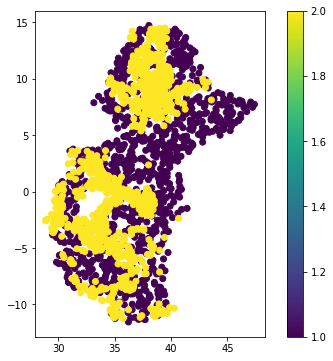

In [58]:
gdf_points.plot(figsize=(8,6), column='class', legend=True)

### Add subsample of points from GFSAD

This will serve as an internal validation dataset.  Append 100 samples from GFSAD per region, 50 crop & 50 non-crop, and shuffle them within the larger dataset.
We need a row identifying them so we can extract after the classification.

In [59]:
#open data
gfsad_shp = 'data/training_validation/GFSAD2015/cropland_prelim_validation_GFSAD.shp'
gfsad_gdf = gpd.read_file(gfsad_shp)

#clip to AEZ
gfsad_gdf = gpd.overlay(gfsad_gdf,aez,how='intersection')

In [60]:
#sample 50 points from each class
crops = gfsad_gdf[gfsad_gdf['class']==1].sample(n=50).reset_index(drop=True)
noncrops = gfsad_gdf[gfsad_gdf['class']==0].sample(n=50).reset_index(drop=True)

#reclassify class int to match GFSAD scheme 
crops['class'] = np.where(crops['class'] == 1,2, crops['class'])
noncrops['class'] = np.where(noncrops['class'] == 0,1, crops['class'])

In [62]:
#add a column to identify samples
crops['GFSAD_sample']=True
noncrops['GFSAD_sample']=True
gdf_points['GFSAD_sample']=False

In [63]:
# Add GFSAD samples to dataset
gdf_points = pd.concat([gdf_points,crops,noncrops]).reset_index(drop=True).drop(columns=['ID','CODE','COUNTRY','index'])

#add a PLOTID field to satisfy Collect Earth
gdf_points['PLOTID'] = range(0,len(gdf_points))
gdf_points['SAMPLEID'] = range(0,len(gdf_points))

### Shuffle rows so classes aren't sequential in CEO

In [69]:
gdf_points = gdf_points.sample(frac=1).reset_index(drop=True)

### Convert points to square polygons

In [77]:
#set radius (in metres) around points
radius = 30

#convert to equal area to set polygon size in metres
gdf_poly = gdf_points.to_crs('EPSG:6933')

#create circle buffer around points, then find envelope
gdf_poly['geometry'] = gdf_poly['geometry'].buffer(radius).envelope

#Convert back to lat/lon
gdf_poly = gdf_poly.to_crs('EPSG:4326')

In [78]:
#export to file
gdf_poly.to_file(results + '_polys.shp')

gdf_points.to_file(results + '_points.shp')